## Polar amplification and feedbacks

In this notebook, read in multiple large ensembles <br>
-historical, historicalNat, historicalMisc p4 (AA), historicalMisc p6 (SO)<br>

Compute global average SAT and north polar SAT<br>
Compute polar amplification<br>
Compute zonal average SAT<br>
Compute anomalies b/w two time periods (?)<br>
Compute trends over some time period (?)<br>
<br>
Compute absorbed solar: rsds - rsus (note, i created files: abssol)<br>
  <li>probably only over ocean.

### Set up metadata for reading in LE data

In [89]:
import xarray as xr
import cccmautils as cutl
import dataset_utils as dsu

%matplotlib inline 

casename='historical'; timeext='195001-202012'
# 1 v 2: past historical comparison
timesel1='1950-01-01,1969-12-31' # 20 years
timesel2='1996-01-01,2015-12-31' # 20 years
# 3 vs 4 : standard future projection comparison. 100 years apart
# 3b vs 4 : hoping "control" time period already doesn't have much sea ice
#           to see how PHT changes after ice has gone away. Check ice.
timesel3='1981-01-01,2000-12-31' # 20 years
timesel3b='2051-01-01,2070-12-31' # 20 years
timesel4='2081-01-01,2100-12-31' # 20 years
    

threed=False # load and process 3-D variables?

# for testing, set these here:
field='tas'
comp='Amon'
pnum='1'

TIMESEL=('1950','2012') # all ensembles have these years?

compDT = {'tas': 'Amon',
          'sianh': 'OImon',
          'nettoa':'Amon',
          'abssol':'Amon',
          'ts':'Amon', 
          'ta':'Amon','hus':'Amon'}
pnumDT = {'all':'1', 'nat':'1','aa':'4','so':'6',
          'ghg':'1'}
ensnamesDT = {'all':'historical', 'nat':'historicalNat',
              'aa':'historicalMisc','so':'historicalMisc',
              'ghg':'historicalGHG'}
timeextDT={'all':'195001-202012',
           'nat': '195001-202012',
           'aa': '195001-202012',
           'so': '195001-200012',
           'ghg':'185001-201212'}

dirsDT = {'all':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'nat':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'aa':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'so':('/Users/kelly/DATA/CanSISE/CanESM2/LE/','-r?'),
          'ghg':('/Users/kelly/DATA/CanSISE/CanESM2/','')}

colordt = {'all':'r',
           'nat':'0.5',
           'aa':'green',
           'ghg':'orange',
           'so':'cyan'}

#basepath='/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/'
#fn = basepath+field+'/'+field+'_'+comp+'_CanESM2_'+casename+'-r'+str(rnum)+'_r'+str(eii)+'i1p'+pnum+'_'+timeext+'.nc'
#print fn
#ds = xr.open_dataset(fn)
#print ds

### Define functions
#### move to class : dataset_utils @@

In [ ]:

'''
def get_areaweights_ds(ds,model='CanESM2'):
    
    awgts=cutl.calc_areawgts(lat=ds.lat.data,lon=ds.lon.data,model='CanESM2')
    area_weights = xr.DataArray(awgts, coords=[ds.lat,ds.lon],name='area_weight')

    # why is the assertion failed? 
    #  The sum is not within tolerance level for some reason,
    #  even thought weights are produced by dividing by the sum
    #np.testing.assert_allclose(area_weights.sum(),1)
    
    return area_weights

def calc_areaweight_mean_ds(ds,dim=None):

    """ Calculates area-weighted mean of the input Dataset (or DataArray?? test)
        If the input ds is a subregion, this should still work. (tested with polcap60)
    
        return area-weighted values in a Dataset (or DataArray?? test)
    """
    aweights = get_areaweights_ds(ds)

    if dim!=None: 
        return (aweights * ds).sum(dim=dim)
    else: 
        return (aweights * ds).sum()


# weighted seasonal / annual average
# code from (modified): http://xarray.pydata.org/en/stable/examples/monthly-means.html
def get_dpm(time):#, calendar='standard'):
    """
    return a array of days per month corresponding to the months provided in `months`
    """
    month_length = np.zeros(len(time), dtype=np.int)

    cal_days = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]#dpm[calendar]

    for i, (month, year) in enumerate(zip(time.month, time.year)):
        month_length[i] = cal_days[month]
        #if leap_year(year, calendar=calendar):
        #    month_length[i] += 1
    return month_length

def calc_seasonal_mean_ds(ds):
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index()),
                                coords=[ds.time], name='month_length')

    # Calculate the month weights by grouping by 'time.season'.
    # Conversion to float type ('astype(float)') only necessary for Python 2.x
    mweights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()

    # Test that the sum of the weights for each season is 1.0
    np.testing.assert_allclose(mweights.groupby('time.season').sum().values, np.ones(4))

    # Calculate the weighted average
    return (ds * mweights).groupby('time.season').sum(dim='time')
    

def calc_annual_mean_ds(ds):
    
    # Make a DataArray with the number of days in each month, size = len(time)
    month_length = xr.DataArray(get_dpm(ds.time.to_index()),
                                coords=[ds.time], name='month_length')

    # Calculate the month weights by grouping by 'time.year'.
    # Conversion to float type ('astype(float)') only necessary for Python 2.x
    mweights = month_length.groupby('time.year') / month_length.astype(float).groupby('time.year').sum()

    nyear = len(ds.groupby('time.year').mean().year)
    
    # Test that the sum of the weights for each year is 1.0
    np.testing.assert_allclose(mweights.groupby('time.year').sum().values, 
                               np.ones(nyear))

    # Calculate the weighted average
    return (ds * mweights).groupby('time.year').sum(dim='time')
    

def calc_monthly_mean_ds(ds):
    
    return ds.groupby('time.month').mean(dim='time')


def calc_totseaicearea(ds,isarea=False): #fld,lat,lon,isarea=False,model='CanESM2'):
    """ calculate total sea ice area
           returns nh,sh
           input is expected to be time x lat x lon SEA ICE CONC
              unless isarea=True

        @@ needs testing 9/9/2014
    """
    if isarea:
        sia=fld 
    else:
        sia = calc_seaicearea(fld,lat,lon,model=model)

        
    awgts=cutl.calc_areawgts(lat=ds.lat.data,lon=ds.lon.data,model='CanESM2')
    area_weights = xr.DataArray(awgts, coords=[ds.lat,ds.lon],name='area_weight')
    
    # Changed to ma.sum() on 12/10/14
    nh = ma.sum(ma.sum(sia[...,lat>0,:],axis=-1),axis=-1)
    sh = ma.sum(ma.sum(sia[...,lat<0,:],axis=-1),axis=-1)

    return nh,sh
'''

### Read in control (PI) TAS, abssol, sianh

In [91]:
""" Note that due to a limitation in pandas(?) datetime, the piControl
    time axis isn't read in properly, so I can't use groupby, etc.
    I will try to use cdo to set the time axis to 1000 years earlier and see if that works.
    
    From user guide:
    To set the time axis to 1987-01-16 12:00:00 with an increment of one month for each timestep use:
   
    cdo settaxis,1987-01-16,12:00:00,1mon infile outfile
    This didn't work (introduced new error). Instead, use shifttime. 
    # Related to this issue: https://github.com/pandas-dev/pandas/issues/7307
    # .  and this: https://github.com/spencerahill/aospy/issues/98
    # So I shifted the time axis with cdo
    # cdo shifttime,-1000years tas_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc 
    # .    tas_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
    
   
    """

# Read in the control data: all ~996 years of piControl
#fn='/Users/kelly/DATA/DataDisk/piControl/'+field+'/'+'piControl_'+field+'_2015-3010_ts.nc'
# Read in the control data: the ~ last 100 years of piControl
#fn='/Users/kelly/DATA/DataDisk/piControl/piControl_'+field+'_2911-3010_ts.nc'

# Reading in piControl dates doesn't work right and grouby can't be used.
# Related to this issue: https://github.com/pandas-dev/pandas/issues/7307
# .  and this: https://github.com/spencerahill/aospy/issues/98
# So I shifted the time axis with cdo
# cdo shifttime,-1000years tas_Amon_CanESM2_piControl_r1i1p1_291101-301012.nc 
# .    tas_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc

ctlDS={}; ctlmapds={}; ctlgmds={}
for field in ('tas','sianh','abssol'): #'nettoa'):
    fn='/Users/kelly/DATA/DataDisk/piControl/'+field+'/'+field+\
       '_'+compDT[field]+'_CanESM2_piControl_r1i1p1_191101-201012.nc'#291101-301012.nc'
    
    print fn
    ctlDS[field] = xr.open_dataset(fn)
    #print ctlds
    print ctlDS[field][field].data.shape

    print ctlDS[field].dims['time']

    ctlclimtsds = ctlDS[field].groupby('time.year').mean('time') # year [x lat x lon]    
    if field not in ('sianh',):
        ctlmapds[field] = ctlclimtsds.mean('year') # lat x lon climo
        ctlgmds[field] = calc_areaweight_mean_ds(ctlclimtsds,dim=('lat','lon')).mean()
        print ctlgmds[field] # climo global mean, time mean
    else:
        ctlgmds[field] = ctlclimtsds.mean()

/Users/kelly/DATA/DataDisk/piControl/tas/tas_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
(1200, 64, 128)
1200
<xarray.Dataset>
Dimensions:    ()
Data variables:
    lon_bnds   float64 178.6
    lat_bnds   float64 -1.418e-13
    time_bnds  float64 4.051e+04
    tas        float64 286.8
/Users/kelly/DATA/DataDisk/piControl/sianh/sianh_OImon_CanESM2_piControl_r1i1p1_191101-201012.nc
(1200, 1, 1)
1200
/Users/kelly/DATA/DataDisk/piControl/abssol/abssol_Amon_CanESM2_piControl_r1i1p1_191101-201012.nc
(1200, 64, 128)
1200
<xarray.Dataset>
Dimensions:    ()
Data variables:
    lon_bnds   float64 178.6
    lat_bnds   float64 -1.418e-13
    time_bnds  float64 4.051e+04
    abssol     float64 164.3


### Read in TAS, NETTOA, ABSSOL, and SIANH for historical
### Read in TAS, SIANH, ABSSOL for historicalNat, and historicalMisc (AA)

In [92]:
caseDS={}

# 2D vars
for ensname in ('all','nat','aa','ghg','so'):#ensnamesDT:
    casename=ensnamesDT[ensname]
    pnum=pnumDT[ensname]
    timeext = timeextDT[ensname]
    basepath,subd = dirsDT[ensname]
    fldDS={}
    #pnum='1'; casename='historical'; 
    #basepath='/Users/kelly/DATA/CanSISE/CanESM2/LE/'+casename+'-r?/'

    for field in ('tas','ts','nettoa','sianh','abssol'):
        
        if ensname in ('aa','so') and field in ('nettoa'): 
            continue # don't have nettoa calculated yet
        if ensname in ('so',) and field in ('abssol','sianh'):
            continue
            
        comp = compDT[field]
        fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
             subd+'_r*i1p'+pnum+'_'+timeext+'.nc'
        print fn
        # this creates a new dimension to concatenate on
        fldDS[field] = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
        #print fldDS[field]

    caseDS[ensname] = fldDS

# get lat,lon once
lat = caseDS['all']['tas']['lat']
lon = caseDS['all']['tas']['lon']




/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/tas/tas_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/ts/ts_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/nettoa/nettoa_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/sianh/sianh_OImon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historical-r?/abssol/abssol_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/tas/tas_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/ts/ts_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/nettoa/nettoa_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc
/Users/kelly/DATA/CanSISE/CanESM2/LE//historicalNat-r?/sianh/sianh_OImon_Ca

In [93]:
# Tried to merge the different fields of one case/ensemble into one DS but it
# doesn't work b/c of time_bnds (not sure why/how)
# MergeError: conflicting values for variable u'time_bnds' on objects to be combined:
#first value: <xarray.Variable (ensemble: 50, time: 852, bnds: 2)>
#dask.array<concate..., shape=(50, 852, 2), dtype=float64, chunksize=(1, 852, 2)>
#second value: <xarray.Variable (ensemble: 50, time: 852, nb2: 2)>
#dask.array<concate..., shape=(50, 852, 2), dtype=datetime64[ns], chunksize=(1, 852, 2)>

# for some reason sianh has its bounds dimension called something else.
# if don't try to merge that variable, it works! meanwhile, the variable sic has 
#  the right name.
testmerge = xr.merge([fldDS['tas'],fldDS['ts']])#fldDS['sianh'],

In [24]:
print testmerge
print '============'
print caseDS['ghg']
print '============'
print caseDS['all']

<xarray.Dataset>
Dimensions:    (bnds: 2, ensemble: 5, lat: 64, lon: 128, time: 756)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ...
  * lat        (lat) float64 -87.86 -85.1 -82.31 -79.53 -76.74 -73.95 -71.16 ...
  * lon        (lon) float64 0.0 2.812 5.625 8.438 11.25 14.06 16.88 19.69 ...
    height     float64 2.0
Dimensions without coordinates: bnds, ensemble
Data variables:
    time_bnds  (ensemble, time, bnds) float64 3.65e+04 3.653e+04 3.653e+04 ...
    lat_bnds   (ensemble, lat, bnds) float64 -90.0 -86.48 -86.48 -83.7 -83.7 ...
    lon_bnds   (ensemble, lon, bnds) float64 -1.406 1.406 1.406 4.219 4.219 ...
    tas        (ensemble, time, lat, lon) float64 239.3 239.1 238.9 238.7 ...
    ts         (ensemble, time, lat, lon) float64 238.6 238.4 238.2 238.0 ...
{'ts': <xarray.Dataset>
Dimensions:    (bnds: 2, ensemble: 5, lat: 64, lon: 128, time: 756)
Coordinates:
  * time       (time) datetime64[ns] 1950-01-16T12:00:00 1950-02-15 ...
  * lat

In [244]:
if threed:
    # Access 3D vars on external? Yes they are huge
    for ensname in ('all','nat'):#,'aa'):#ensnamesDT:
        casename=ensnamesDT[ensname]
        pnum=pnumDT[ensname]
        fldDS={}
        #basepath='/Users/kelly/DATA/CanSISE/CanESM2/LE/'+casename+'-r?/'
        basepath='/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/'+casename+'-r?/'

        for field in ('ta',):#'hus'):

            comp = compDT[field]
            fn = basepath+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
                '-r?_r*i1p'+pnum+'_'+timeext+'.nc'
            print fn
            # this creates a new dimension to concatenate on
            fldDS[field] = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True)
            #print fldDS[field]

        caseDS[ensname] = fldDS

    # get lev once
    lev = caseDS['all']['ta']['plev']



/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/historical-r?/ta/ta_Amon_CanESM2_historical-r?_r*i1p1_195001-202012.nc
/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE/historicalNat-r?/ta/ta_Amon_CanESM2_historicalNat-r?_r*i1p1_195001-202012.nc


KeyError: 'lev'

### Plot annual average, global average, ensemble avg timeseries


<class 'xarray.core.dataset.Dataset'>
<xarray.Dataset>
Dimensions:    (bnds: 2, year: 63)
Coordinates:
  * year       (year) int64 1950 1951 1952 1953 1954 1955 1956 1957 1958 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (year, bnds) float64 3.667e+04 3.67e+04 3.703e+04 3.706e+04 ...
    lat_bnds   (year, bnds) float64 -1.396 1.396 -1.396 1.396 -1.396 1.396 ...
    lon_bnds   (year, bnds) float64 177.2 180.0 177.2 180.0 177.2 180.0 ...
    tas        (year) float64 287.1 287.1 287.1 287.1 287.1 287.1 287.1 ...
<xarray.DataArray 'lat' (lat: 10)>
array([ 62.787352,  65.577607,  68.367756,  71.157752,  73.947515,  76.7369  ,
        79.525606,  82.312913,  85.096527,  87.863799])
Coordinates:
  * lat      (lat) float64 62.79 65.58 68.37 71.16 73.95 76.74 79.53 82.31 ...
Attributes:
    bounds:         lat_bnds
    units:          degrees_north
    axis:           Y
    long_name:      latitude
    standard_name:  latitude
<xarray.Dataset>
Dimensions:    (bnds: 2

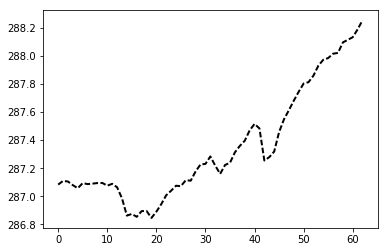

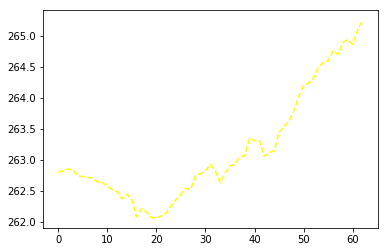

In [94]:
cutl=reload(cutl)

# Use my defined functions, that operate on Dataset/DataArray



# Now try to do w/ Dataset/DataArray 
# Example of day-weighted seasonal average: 
# .   http://xarray.pydata.org/en/stable/examples/monthly-means.html
# # Make a DataArray with the number of days in each month, size = len(time)
#month_length = xr.DataArray(get_dpm(ds.time.to_index(), calendar='noleap'),
#                            coords=[ds.time], name='month_length')
#
## Calculate the weights by grouping by 'time.season'.
## Conversion to float type ('astype(float)') only necessary for Python 2.x
#weights = month_length.groupby('time.season') / month_length.astype(float).groupby('time.season').sum()
#
## Test that the sum of the weights for each season is 1.0
#np.testing.assert_allclose(weights.groupby('time.season').sum().values, np.ones(4))
#
## Calculate the weighted average
#ds_weighted = (ds * weights).groupby('time.season').sum(dim='time')


tasds = caseDS['all']['tas']
#print type(globavg)
globavgds = calc_areaweight_mean_ds(tasds.groupby('time.year').mean(dim=('time','ensemble')),dim=('lat','lon')) #<--- Dataset

print type(globavgds)
print globavgds

fig,ax=plt.subplots(ncols=1)
ax.plot(globavgds['tas'],color='k',linewidth=2,linestyle='dashed')



# Will this work on a subregion? Yes!
polsl = slice(60,90)
polds = tasds.groupby('time.year').mean(dim=('time','ensemble')).sel(lat=polsl) # <--- Dataset

print polds['lat'] # <--- DataArray

polavgds = calc_areaweight_mean_ds(polds,dim=('lat','lon')) # <--- Dataset

print polavgds

fig,ax=plt.subplots(ncols=1)
#ax.plot(pltpolw,'r')
#ax.plot(pltpol.tas,'k')
ax.plot(polavgds.tas,color='yellow',linestyle='dashed')


### Calculate anomalies b/w simulation beginning and end
#### Eventually switch to trend calc

In [95]:

ersl = slice(1950,1959)
#lasl = slice(2011,2020)
lasl = slice(2003,2012)
early={}; late={}
for cs in ('all','nat','aa','ghg'):
    
    eflddt={}; lflddt={}; testpol={}
    for field in ('tas','sianh','nettoa','abssol','poltas'):
        
        if field=='nettoa' and cs in ('aa',):
            pass
        elif field=='sianh': # already 1-D
            fldda = caseDS[cs][field][field]
            
            # this cmd does annual avg, selects years and does time average: ann average climo
            eflddt[field] = fldda.groupby('time.year').mean('time').sel(year=ersl).mean(dim='year')
            lflddt[field] = fldda.groupby('time.year').mean('time').sel(year=lasl).mean(dim='year')
            
        elif field=='poltas': # calc polar mean
            fldda = caseDS[cs]['tas']['tas']
            
            # this cmd groups by year, then averages (annual avg), then selects years and does time avg
            emap = fldda.groupby('time.year').mean('time').sel(year=ersl).mean(dim='year') # 50 maps
            lmap = fldda.groupby('time.year').mean('time').sel(year=lasl).mean(dim='year') # 50 maps

            # this cmd selects latitudes, groups by ensemble, and averages everything else (space) giving polar mean
            #polds = tasds.groupby('time.year').mean(dim=('time','ensemble')).sel(lat=polsl) # <--- Dataset
            #polavgds = calc_areaweight_mean_ds(polds,dim=('lat','lon')) # <--- Dataset
            eflddt[field] = calc_areaweight_mean_ds(emap.sel(lat=polsl),dim=('lat','lon'))
            lflddt[field] = calc_areaweight_mean_ds(lmap.sel(lat=polsl),dim=('lat','lon'))
            #eflddt[field] = emap.sel(lat=slice(60,90)).groupby('ensemble').mean() # polar mean for e/ ensemble
            #lflddt[field] = lmap.sel(lat=slice(60,90)).groupby('ensemble').mean() # polar mean for e/ ensemble
        else:
            # this cmd does annual avg, selects years and does time avg, then group by ensemble and avg everything else (space)
            emap = caseDS[cs][field][field].groupby('time.year').mean('time').sel(year=ersl).mean(dim='year')
            lmap = caseDS[cs][field][field].groupby('time.year').mean('time').sel(year=lasl).mean(dim='year')
            eflddt[field] = calc_areaweight_mean_ds(emap,dim=('lat','lon'))
            lflddt[field] = calc_areaweight_mean_ds(lmap,dim=('lat','lon'))
            #eflddt[field] = caseDS[cs][field][field].groupby('time.year').mean('time').sel(year=ersl).mean(dim='year').groupby('ensemble').mean()
            #lflddt[field] = caseDS[cs][field][field].groupby('time.year').mean('time').sel(year=lasl).mean(dim='year').groupby('ensemble').mean()

        early[cs]=eflddt
        late[cs]=lflddt
            

all
nat
aa
ghg


(-2, 5)

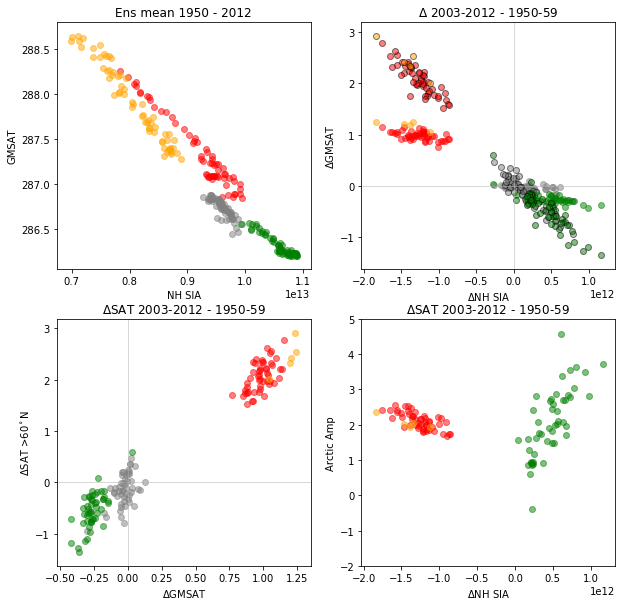

In [97]:


endyear=TIMESEL[1]
styear=str(np.int(TIMESEL[1])-9)

fig,axs = plt.subplots(2,2,figsize=(10,10))
ax=axs[0,0]
# ==== ENSEMBLE MEAN per year ====
for cs in ('all','nat','aa','ghg'):
    #ax.scatter(caseDS[cs]['sianh']['sianh'].groupby('time.year').mean(),
    #            caseDS[cs]['tas']['tas'].groupby('time.year').mean(),color=colordt[cs],alpha=.5)
    
    tssiads = caseDS[cs]['sianh'].groupby('time.year').mean(dim=('time','ensemble'))
    tstasds = calc_areaweight_mean_ds(caseDS[cs]['tas'].groupby('time.year').mean(dim=('time','ensemble')),
                                      dim=('lat','lon'))
    ax.scatter(tssiads.sianh,tstasds.tas,
               color=colordt[cs],alpha=0.5)
ax.set_xlabel('NH SIA')
ax.set_ylabel('GMSAT')
ax.set_title('Ens mean 1950 - '+endyear)

ax=axs[0,1]
# ==== EPOCH DIFFS per ensemble ====
for cs in ('all','nat','aa','ghg'):
    # Global temp vs SIA
    print cs
    ax.scatter((late[cs]['sianh']-early[cs]['sianh']),
               (late[cs]['tas']-early[cs]['tas']),color=colordt[cs],alpha=.5)
    # Polar temp vs SIA
    ax.scatter((late[cs]['sianh']-early[cs]['sianh']),
               (late[cs]['poltas']-early[cs]['poltas']),color=colordt[cs],alpha=.5,edgecolor='k')
ax.axhline(y=0,color='0.7',linewidth=.5)
ax.axvline(x=0,color='0.7',linewidth=.5)
ax.set_xlabel('$\Delta$NH SIA')
ax.set_ylabel('$\Delta$GMSAT')
ax.set_title('$\Delta$ '+styear+'-'+endyear +' - 1950-59')

ax=axs[1,0]
for cs in ('all','nat','aa','ghg'):
    # Global temp vs Polar temp
    ax.scatter((late[cs]['tas']-early[cs]['tas']),
               (late[cs]['poltas']-early[cs]['poltas']),color=colordt[cs],alpha=.5)
ax.axhline(y=0,color='0.7',linewidth=.5)
ax.axvline(x=0,color='0.7',linewidth=.5)
ax.set_ylabel('$\Delta$SAT >60$^\circ$N')
ax.set_xlabel('$\Delta$GMSAT')
ax.set_title('$\Delta$SAT '+styear+'-'+endyear +' - 1950-59')

ax=axs[1,1]
for cs in ('all','aa','ghg'): # leave out NAT b/c denom is too small
    # SIA vs Arctic Amp
    ax.scatter((late[cs]['sianh']-early[cs]['sianh']),
               (late[cs]['poltas']-early[cs]['poltas'])/(late[cs]['tas']-early[cs]['tas']),
                color=colordt[cs],alpha=.5)    
ax.set_xlabel('$\Delta$NH SIA')
ax.set_ylabel('Arctic Amp')
ax.set_title('$\Delta$SAT '+styear+'-'+endyear +' - 1950-59')
ax.set_ylim((-2,5))



all
regress mm,bb,pval,rval: 0.610250603459 287.031891326 2.32767373021e-11 0.722450944
nat
regress mm,bb,pval,rval: 0.108550142614 286.719281512 0.00276209611865 0.370962280579
ghg
regress mm,bb,pval,rval: 1.2640939022 286.938600422 9.12909253939e-16 0.809939910122
all
regress mm,bb,pval,rval: -0.348746204794 1.22645872892 0.000704011204371 -0.463273669115
nat
regress mm,bb,pval,rval: -0.144787870027 -0.0223543549797 0.255986021487 -0.163698586423
ghg
regress mm,bb,pval,rval: 0.0391534800885 1.15861722351 0.951121720754 0.0383983488048


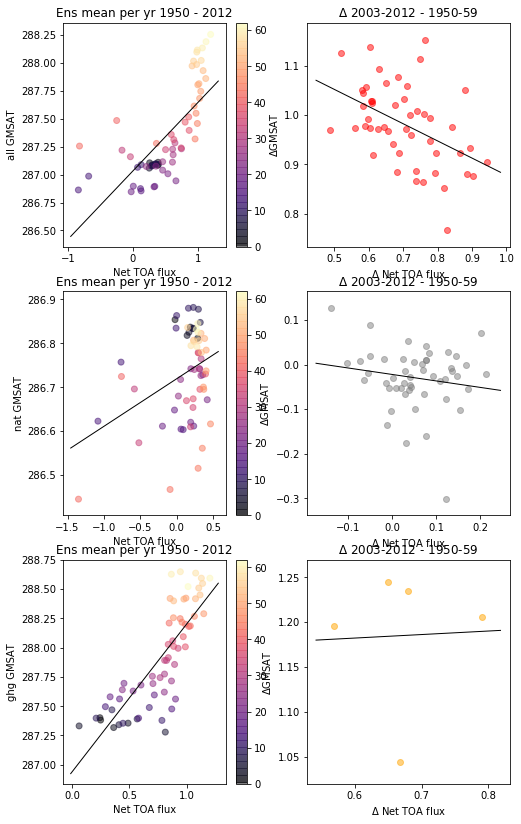

In [98]:
#xx = np.arange(71) # use for colors - dsall['time.year'] didn't work.


fig,axs=plt.subplots(ncols=2,nrows=3,figsize=(8,14))
rowii=0
for cs in ('all','nat','ghg'):    
    print cs
    ax=axs[rowii,0]
    tstasds = calc_areaweight_mean_ds(caseDS[cs]['tas'].groupby('time.year').mean(dim=('time','ensemble')),
                                      dim=('lat','lon'))
    tstoads = calc_areaweight_mean_ds(caseDS[cs]['nettoa'].groupby('time.year').mean(dim=('time','ensemble')),
                                      dim=('lat','lon'))
    xx=np.arange(tstoads.year.shape[0])
    sc = ax.scatter(tstoads.nettoa,tstasds.tas,c=xx,cmap='magma',alpha=.5)
    cplt.add_regressline(tstoads.nettoa,tstasds.tas, ax=ax)
    
    ax.set_xlabel('Net TOA flux')
    ax.set_ylabel(cs + ' GMSAT')
    ax.set_title('Ens mean per yr 1950 - '+endyear)
    rowii+=1
    fig.colorbar(sc,ax=ax,orientation='vertical')

rowii=0
for cs in ('all','nat','ghg'):
    print cs
    ax=axs[rowii,1]
    # Net TOA vs Global temp
    ax.scatter((late[cs]['nettoa']-early[cs]['nettoa']),
               (late[cs]['tas']-early[cs]['tas']),color=colordt[cs],alpha=.5)
    cplt.add_regressline((late[cs]['nettoa']-early[cs]['nettoa']),
                      (late[cs]['tas']-early[cs]['tas']),ax=ax)
    #ax.axhline(y=0,color='0.7',linewidth=.5)
    #ax.axvline(x=0,color='0.7',linewidth=.5)
    ax.set_xlabel('$\Delta$ Net TOA flux')
    ax.set_ylabel('$\Delta$GMSAT')
    ax.set_title('$\Delta$ '+styear+'-'+endyear+ ' - 1950-59')
    rowii+=1


In [43]:
?cplt.add_regressline

#### Regarding the above Figure:
In time, on a timescale of a year, the greater the TOA flux imbalance,
the greater the global temperature.<br>
However, over a multidecadal timescale, the greater the trend in TOA flux imbalance,
the smaller the global temperature change. <br>
Does this imply<br>
<li> on an interannual basis, the global temp responds to the TOA imbalance
<li> on a multidecadal basis, the TOA imbalance depends on the efficiency of the global T response?
<br>
<br>
In other words, on a multidecadal timescale, the planet has time to respond to the TOA
flux imbalance caused by GHG increase, and so a warmer planet means it is less out of balance w/ the RF.


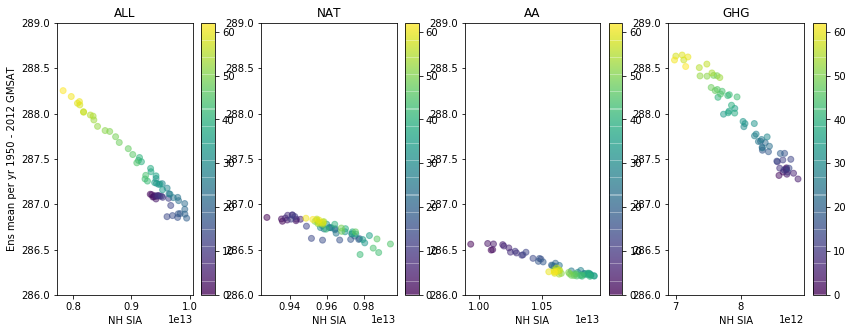

In [99]:
plotcases=('all','nat','aa','ghg')
ylims=(286,289)
fig,axs = plt.subplots(1,len(plotcases),figsize=(len(plotcases)*3.5,5))
aii=0
for cs in plotcases:
    ax=axs[aii]
    tstasds = calc_areaweight_mean_ds(caseDS[cs]['tas'].groupby('time.year').mean(dim=('time','ensemble')),
                                      dim=('lat','lon'))
    sc=ax.scatter(caseDS[cs]['sianh']['sianh'].groupby('time.year').mean(),
                 tstasds.tas,c=xx,alpha=.5)
    ax.set_xlabel('NH SIA')
    if aii==0:
        ax.set_ylabel('Ens mean per yr 1950 - '+endyear+' GMSAT')
    ax.set_title(str.upper(cs))
    ax.set_ylim(ylims)
    fig.colorbar(sc,ax=ax,orientation='vertical')
    aii+=1



### retain enesmble dim

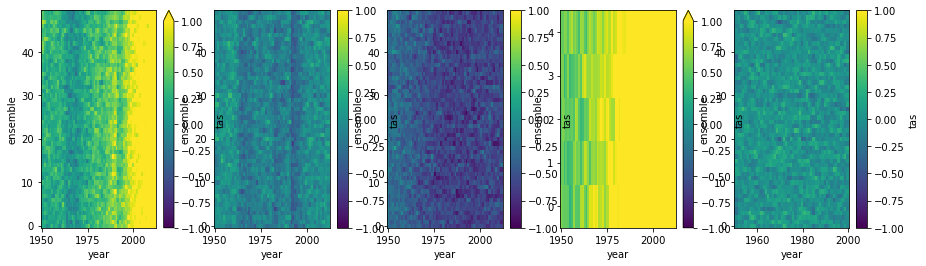

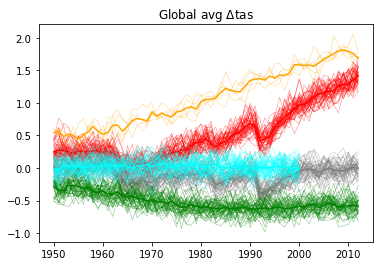

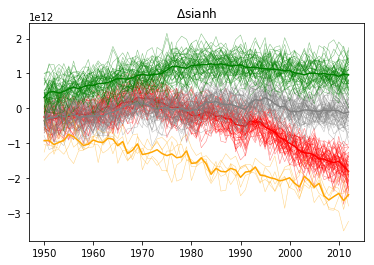

In [100]:
# how to plot timeseries but retain ensemble dimension
# might be a better way(?)


field='tas'
# ANOMALIES
enstsds={}
for cs in ('all','nat','aa','ghg','so'):
    maps = caseDS[cs][field].groupby('time.year').mean('time')
    enstsds[cs] = calc_areaweight_mean_ds(maps,dim=('lat','lon')) - ctlgmds[field][field] # leave ensemble,time dim
    # dims are ensemble x year

# default is a 2-D plot
fig,axs = plt.subplots(ncols=5,figsize=(15,4))
for ax,cs in zip(axs,('all','nat','aa','ghg','so')):
    enstsds[cs][field].T.plot(ax=ax,vmin=-1,vmax=1)#,cmap='magma')
    



# WRONG dsannpd = pd.DataFrame(dsannts,index='time',columns='ensemble')

# override default 2-D plot

plt.figure()
for cs in ('all','nat','aa','ghg','so'):
    ret = plt.plot(enstsds[cs].year,enstsds[cs][field].data,
                   color=colordt[cs],alpha=.5,linewidth=.5)
    plt.plot(enstsds[cs].year,enstsds[cs].mean(dim='ensemble')[field],
             color=colordt[cs])
    
plt.title('Global avg $\Delta$' + field)


field='sianh'
enssiads={}
for cs in ('all','nat','aa','ghg'):#,'so'):
    enssiads[cs] = caseDS[cs][field].groupby('time.year').mean('time')-ctlgmds[field][field]
    # dims are ensemble x year

plt.figure()
for cs in ('all','nat','aa','ghg'):#,'so'):
    ret = plt.plot(enssiads[cs].year,np.squeeze(enssiads[cs][field].data),
                   color=colordt[cs],alpha=.5,linewidth=.5)
    plt.plot(enssiads[cs].year,np.squeeze(enssiads[cs].mean(dim='ensemble')[field]),
             color=colordt[cs])
    
plt.title('$\Delta$' + field)




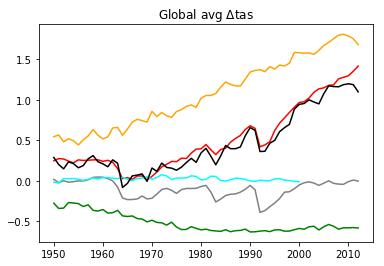

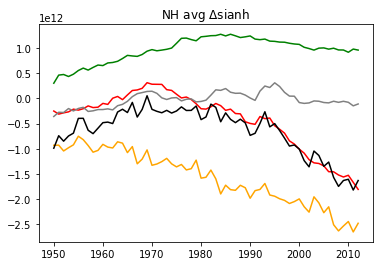

In [101]:
field='tas'
plt.figure()
for cs in ('all','nat','aa','ghg','so'):
    plt.plot(enstsds[cs].year,enstsds[cs].mean(dim='ensemble')[field],color=colordt[cs])

sumforcing=enstsds['ghg'].mean(dim='ensemble')[field] +\
           enstsds['nat'].mean(dim='ensemble')[field] +\
           enstsds['aa'].mean(dim='ensemble')[field] #+\
           #enstsds['so'].mean(dim='ensemble')[field]
plt.plot(enstsds['all'].year,sumforcing,color='k')    
plt.title('Global avg $\Delta$' + field)


field='sianh'
plt.figure()
for cs in ('all','nat','aa','ghg'):#,'so'):
    plt.plot(enssiads[cs].year,np.squeeze(enssiads[cs].mean(dim='ensemble')[field]),
             color=colordt[cs])

sumforcing=enssiads['ghg'].mean(dim='ensemble')[field].data +\
           enssiads['nat'].mean(dim='ensemble')[field].data +\
           enssiads['aa'].mean(dim='ensemble')[field].data #+\
           #enstsds['so'].mean(dim='ensemble')[field]
plt.legend(('all','nat','aa','ghg','SUM'))
plt.plot(enssiads['all'].year,np.squeeze(sumforcing),color='k')    
plt.title('NH avg $\Delta$' + field)


## Test sianh

#Test python sianh calc against old shell script calc
casename='historical'
field='sianhtest'
comp='OImon'
subd='-r?'
basepath2 = '/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE'
fn = basepath2+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
        subd+'_r*i1p1_'+timeextDT['all']+'.nc'
print fn
#this creates a new dimension to concatenate on
testsia = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
#testsiaplt = testsia.groupby('time.year').mean('time')-ctlgmds['sianh']['sianh']

casename='historicalNat'
field='sianhtest'
comp='OImon'
subd='-r?'
basepath2 = '/Volumes/KellyDataDisk/home/work/DATA/CanESM2/LE'
fn = basepath2+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
        subd+'_r*i1p1_'+timeextDT['all']+'.nc'
print fn
#this creates a new dimension to concatenate on
testsianat = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))


field='sianh'
fn = basepath2+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
        subd+'_r*i1p1_'+timeextDT['all']+'.nc'
print fn
#this creates a new dimension to concatenate on
siaext = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
#siaextplt = siaext.groupby('time.year').mean('time')-ctlgmds['sianh']['sianh']

field='sianh'
fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
        subd+'_r*i1p1_'+timeextDT['all']+'.nc'
print fn
#this creates a new dimension to concatenate on
sialoc = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
#sialocplt = siaext.groupby('time.year').mean('time')-ctlgmds['sianh']['sianh']

cutl=reload(cutl)


plt.figure()
plt.plot(enssiads['all'].year,
         np.squeeze(siaext).groupby('time.year').mean('time').mean(dim='ensemble')['sianh'],
         color='magenta')
plt.plot(enssiads['all'].year,
         np.squeeze(testsia).groupby('time.year').mean('time').mean(dim='ensemble')['sianhtest'],
         color='pink',linestyle='dashed')
plt.plot(enssiads['all'].year,
         np.squeeze(sialoc).groupby('time.year').mean('time').mean(dim='ensemble')['sianh'],
         color='yellow')
plt.legend(('ext','ext test','loc'))


field='sic'
fn = basepath+'/'+casename+subd+'/'+field+'/'+field+'_'+comp+'_CanESM2_'+casename+\
        subd+'_r*i1p1_'+timeextDT['all']+'.nc'
print fn
sicloc = xr.open_mfdataset(fn,concat_dim='ensemble',autoclose=True).sel(time=slice(TIMESEL[0],TIMESEL[1]))
#print sicloc.groupby('time.year').mean('time').mean(dim='ensemble')['sic']
sialocfunc,_ = cutl.calc_totseaicearea(np.squeeze(sicloc.groupby('time.year').mean('time').mean(dim='ensemble')['sic']/100.), 
                        sicloc.lat,sicloc.lon)
#print sialocfunc
plt.plot(enssiads['all'].year, sialocfunc,color='green',linestyle='dotted')

plt.figure()
plt.plot(enssiads['all'].year, sialocfunc,color='green',linestyle='dotted')




plt.figure()
plt.plot(enssiads['all'].year,
         np.squeeze(siaext).groupby('time.year').mean('time').mean(dim='ensemble')['sianh'],
         color='magenta')
plt.plot(enssiads['all'].year,
         np.squeeze(testsia).groupby('time.year').mean('time').mean(dim='ensemble')['sianhtest'],
         color='pink',linestyle='dashed')
plt.plot(enssiads['all'].year,
         np.squeeze(sialoc).groupby('time.year').mean('time').mean(dim='ensemble')['sianh'],
         color='yellow')
plt.plot(enssiads['all'].year,
         sialocfunc,
         color='cyan',linestyle='dotted')
plt.legend(('ext','ext test','loc','func'))


field='sianh'
enssiaclimods={}
for cs in ('all','nat','aa','ghg'):#,'so'):
    enssiaclimods[cs] = caseDS[cs][field].groupby('time.year').mean('time')
    #dims are ensemble x year

plt.figure()
for cs in ('all','nat','aa','ghg'):#,'so'):
    plt.plot(enssiads[cs].year,np.squeeze(enssiads[cs].mean(dim='ensemble')[field]),
             color=colordt[cs])

plt.plot(enssiads['all'].year,np.squeeze(testsiaplt.mean(dim='ensemble')['sianhtest']),color='b',linestyle='dashed')    

plt.title('NH avg $\Delta$' + field)


plt.figure()
for cs in ('all','nat','aa','ghg'):#,'so'):
    plt.plot(enssiaclimods[cs].year,np.squeeze(enssiaclimods[cs].mean(dim='ensemble')[field]),
             color=colordt[cs])

plt.plot(enssiads['all'].year,
         np.squeeze(testsia.groupby('time.year').mean('time').mean(dim='ensemble')['sianhtest']),
         color='b',linestyle='dashed')    
plt.plot(enssiads['all'].year,
         np.squeeze(testsianat.groupby('time.year').mean('time').mean(dim='ensemble')['sianhtest']),
         color='k',linestyle='dashed')  
plt.axhline(ctlgmds['sianh']['sianh'],color='0.7')
plt.title('NH avg ' + field)



## End TESTING

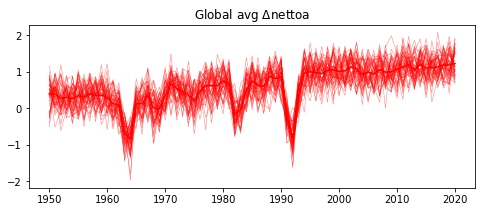

In [137]:
field='nettoa' # only have ALL (no piControl either)
# ANOMALIES
enstsds={}
for cs in ('all',):#'nat','aa'):
    maps = caseDS[cs][field].groupby('time.year').mean('time')
    enstsds[cs] = calc_areaweight_mean_ds(maps,dim=('lat','lon'))# - ctlgmds[field][field] # leave ensemble,time dim
    # dims are ensemble x year

# override default 2-D plot

plt.figure(figsize=(8,3))
for cs in ('all',):#'nat','aa'):
    ret = plt.plot(enstsds[cs].year,enstsds[cs][field].data,color=colordt[cs],alpha=.5,linewidth=.5)
    plt.plot(enstsds[cs].year,enstsds[cs].mean(dim='ensemble')[field],color=colordt[cs])
    
plt.title('Global avg $\Delta$' + field)


In [228]:
# zonal mean temp ANOM with latitude
field='tas'
ctlzm = ctlclimods[field].mean(dim='lon')

dszm={}; dszmanomDT={}; dszmearly={}; dszmlate={}
for cs in ('all','nat','aa'):
    dszm[cs] = caseDS[cs][field].groupby('time.year').mean(dim=('time','lon')) #- ctlzm # couldn't get this to broadcast 
    dszmanomDT[cs] = caseDS[cs][field].groupby('time.year').mean(dim=('time','lon'))[field].data - ctlzm.data
    dszmearly[cs] = dszm[cs].sel(year=slice(1950,1959)).mean(dim='year')
    dszmlate[cs] = dszm[cs].sel(year=slice(2011,2020)).mean(dim='year')

#dsnatzm = caseDS['nat'][field].groupby('time.year').mean(dim=('time','lon'))# - ctlzm
#print dszm
#dsnatzmearly = dsnatzm.sel(year=slice(1950,1959)).mean(dim='year')
#dsnatzmlate = dsnatzm.sel(year=slice(2011,2020)).mean(dim='year')



KeyError: 'There are no fields in dtype float64.'

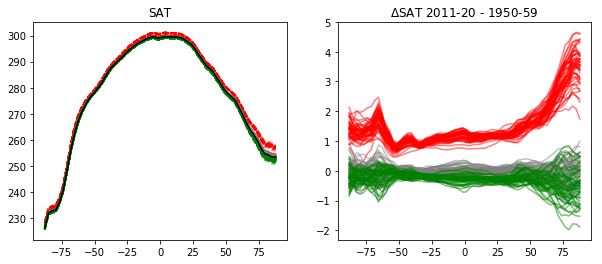

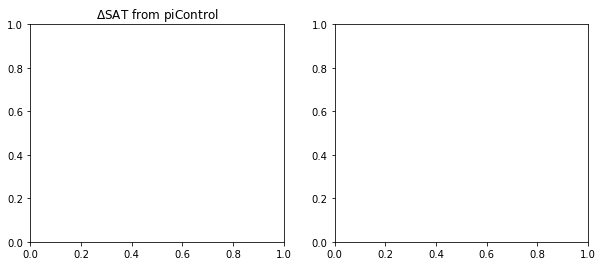

In [229]:
cs='all'
fig,axs = plt.subplots(ncols=2,figsize=(10,4))
axs[0].set_title('SAT')
ret = axs[0].plot(dszm[cs]['lat'],dszmearly[cs][field].data.T,color='r',alpha=.5)
ret = axs[0].plot(dszm[cs]['lat'],dszmlate[cs][field].data.T,color='r',
                  linestyle='dashed',alpha=.5)
cs='nat'
ret = axs[0].plot(dszm[cs]['lat'],dszmearly[cs][field].data.T,color='0.5',alpha=.5)
ret = axs[0].plot(dszm[cs]['lat'],dszmlate[cs][field].data.T,color='0.5',
                  linestyle='dashed',alpha=.5)
cs='aa'
ret = axs[0].plot(dszm[cs]['lat'],dszmearly[cs][field].data.T,color='g',alpha=.5)
ret = axs[0].plot(dszm[cs]['lat'],dszmlate[cs][field].data.T,color='g',
                  linestyle='dashed',alpha=.5)

ret = axs[0].plot(ctlzm['lat'],ctlzm,color='k')

axs[1].set_title('$\Delta$SAT 2011-20 - 1950-59')
ret = axs[1].plot(dszm['all']['lat'],dszmlate['all'][field].data.T-dszmearly['all'][field].data.T,color='r',alpha=.5)
ret = axs[1].plot(dszm['nat']['lat'],dszmlate['nat'][field].data.T-dszmearly['nat'][field].data.T,color='0.5',alpha=.5)
ret = axs[1].plot(dszm['aa']['lat'],dszmlate['aa'][field].data.T-dszmearly['aa'][field].data.T,color='g',alpha=.5)






In [236]:
#print help(dszmanomDT['all'])
print dszmanomDT['all'].all

<bound method Array.all of dask.array<sub-f17..., shape=(71, 50, 64), dtype=float64, chunksize=(1, 1, 64)>>


In [ ]:
fig,axs = plt.subplots(ncols=2,figsize=(10,4))

axs[0].set_title('$\Delta$SAT from piControl')
ret = axs[1].plot(dszm['all']['lat'],dszmanomDT['all'][field].T,color='r',alpha=.5)
ret = axs[1].plot(dszm['nat']['lat'],dszmanomDT['nat'][field].T,color='0.5',alpha=.5)
ret = axs[1].plot(dszm['aa']['lat'],dszmanomDT['aa'][field].T,color='g',alpha=.5)

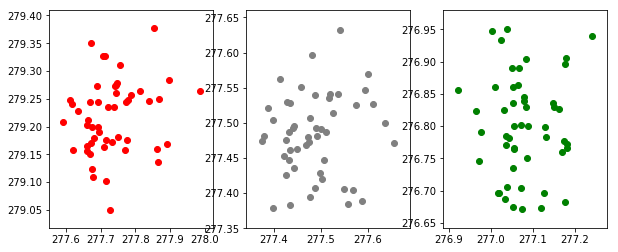

In [219]:
fig,axs=plt.subplots(1,3,figsize=(10,4))
ax=axs[0]
ax.scatter(dszmearly['all'][field].mean('lat'),dszmlate['all'][field].mean('lat'),color='r')

ax=axs[1]
ax.scatter(dszmearly['nat'][field].mean('lat'),dszmlate['nat'][field].mean('lat'),color='0.5')

ax=axs[2]
ax.scatter(dszmearly['aa'][field].mean('lat'),dszmlate['aa'][field].mean('lat'),color='g')


### CC code

In [ ]:
#calc_dX_LME.m


# perturbed runs: single forcing exp averaged over: 1981-2005 (and averaged over ensemble?)
# control: use piControl? CC uses 1000 years

# PSEUDOCODE of CC's matlab:

# get grid info from one of the files: lat, lon, lev, nlat,nlon,nlev
# load 2d variables: 'TS';'TREFHT';'FSNS';'FSDS';'FSNSC';'FSDSC';'FLNT';'FLNTC';'FSNT';'FSNTC'
#   Here would be: gt, tas....
#   Each month read in separately (from separate files I think)

# load 3d variables: T, Q

# compute differences:
#  dQ = log(Q_pert)-log(Q-ctl)
#  dTs = TS_pert - TS_ctl
#    etc... for TAS and T

# read in PS and OCEANFRAC 

# create a mask of "always ocean" grid cells (no changes b/c our control and pert sims?)

# interpolate to kernel grid (CAM3) for e/ level and month 
#    (I am not following this section of code)

# Compute albedo and clearsky albedo, and LW and SW CRF
#   Includes hack to set ocean albedo to 0.06 where it's always ocean
#   (b/c it actually depends on zenith angle..)

# compute differences for albedo, clearsky albedo, LW/SW CRF


# ### Questions for CC:
#   1. Is oceanfrac a constant? I assume so but maybe not for LME?
#   2. Multiple interp loops, why?
#   3. Why do we need surface temp and 2m temp?




In [198]:
# calc_dX_LME

# Read in single-forcing ensembles (read in above).
# Compute monthly average maps.
# Compute anomaly from preindustrial control (TODO: include more years)
# TODO: add variables: T, Q, TS
climoDS={}; climanomDT={}
for ens in ('all','nat','aa'):
    fldDS={}; anomDT={}
    for field in ('tas','abssol'):
        
        tmpfld = caseDS[ens][field].sel(time=slice('1981','2005')).mean(dim='ensemble')
        fldDS[field] = calc_monthly_mean_ds(tmpfld)
        tmpctl = calc_monthly_mean_ds(ctlDS[field])
        anomDT[field] = fldDS[field][field].data - tmpctl[field].data # failed when kept as Dataset
        
    climoDS[ens] = fldDS # just lat x lon
    climanomDT[ens] = anomDT
    
# Result is a map for each month.

#print climoDS




In [1]:
fig,axs=plt.subplots(1,3,figsize=(12,4))
ax=axs[0]
climoDS['all']['tas'].sel(month=12)['tas'].plot(axis=ax)

print climoDS['all']['tas']['tas'].shape

print type(climanomDT['all']['tas'])
print climanomDT['all']['tas'].shape

fig,axs=plt.subplots(1,3,figsize=(10,4))
ax=axs[0]
cplt.kemmap(climanomDT['all']['tas'][11],lat,lon,cmin=-2,cmax=2,axis=ax)
ax=axs[1]
cplt.kemmap(climanomDT['nat']['tas'][11],lat,lon,cmin=-2,cmax=2,axis=ax)
ax=axs[2]
cplt.kemmap(climanomDT['aa']['tas'][11],lat,lon,cmin=-2,cmax=2,axis=ax)


NameError: name 'climoDS' is not defined